In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('../../data/Accidentes_2013_2023.csv')

# Reemplazar los NaN en 'fall_les' con la categoría 'Ignorado'
df['fall_les'] = df['fall_les'].fillna('Ignorado')

# Confirmar la nueva distribución de clases en la variable objetivo
fall_les_distribution = df['fall_les'].value_counts(dropna=False)
print("\nDistribución de clases en 'fall_les' después de la limpieza:\n", fall_les_distribution)


Distribución de clases en 'fall_les' después de la limpieza:
 fall_les
Lesionado    64038
Ignorado     22566
Fallecido    12911
Name: count, dtype: int64


In [2]:
# Separar X e y
X = df.drop(columns=['fall_les'])
y = df['fall_les']

# One-hot encoding de variables categóricas
X_encoded = pd.get_dummies(X, drop_first=True)

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Codificar clase objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)


In [3]:
# Crear el modelo RandomForest
rf_model = RandomForestClassifier(
    n_estimators=100,  # Número de árboles
    max_depth=None,    # Profundidad máxima (None = sin límite)
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',  # Número de características a considerar en cada división
    bootstrap=True,
    random_state=42
)


In [4]:
# 2. Entrenar el modelo
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [5]:
# Evaluar el modelo
# Predicciones en conjunto de prueba
y_pred = rf_model.predict(X_test)

# Métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=le.classes_)

print(f"Exactitud del modelo: {accuracy:.4f}")
print("\nMatriz de confusión:")
print(conf_matrix)
print("\nInforme de clasificación:")
print(classification_rep)

Exactitud del modelo: 0.8868

Matriz de confusión:
[[ 1234     0  2639]
 [    0  6770     0]
 [  740     0 18472]]

Informe de clasificación:
              precision    recall  f1-score   support

   Fallecido       0.63      0.32      0.42      3873
    Ignorado       1.00      1.00      1.00      6770
   Lesionado       0.87      0.96      0.92     19212

    accuracy                           0.89     29855
   macro avg       0.83      0.76      0.78     29855
weighted avg       0.87      0.89      0.87     29855



In [6]:
# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_scaled, y_encoded, cv=cv, scoring='accuracy')
print(f"\nExactitud con validación cruzada: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Exactitud con validación cruzada: 0.8861 (+/- 0.0043)


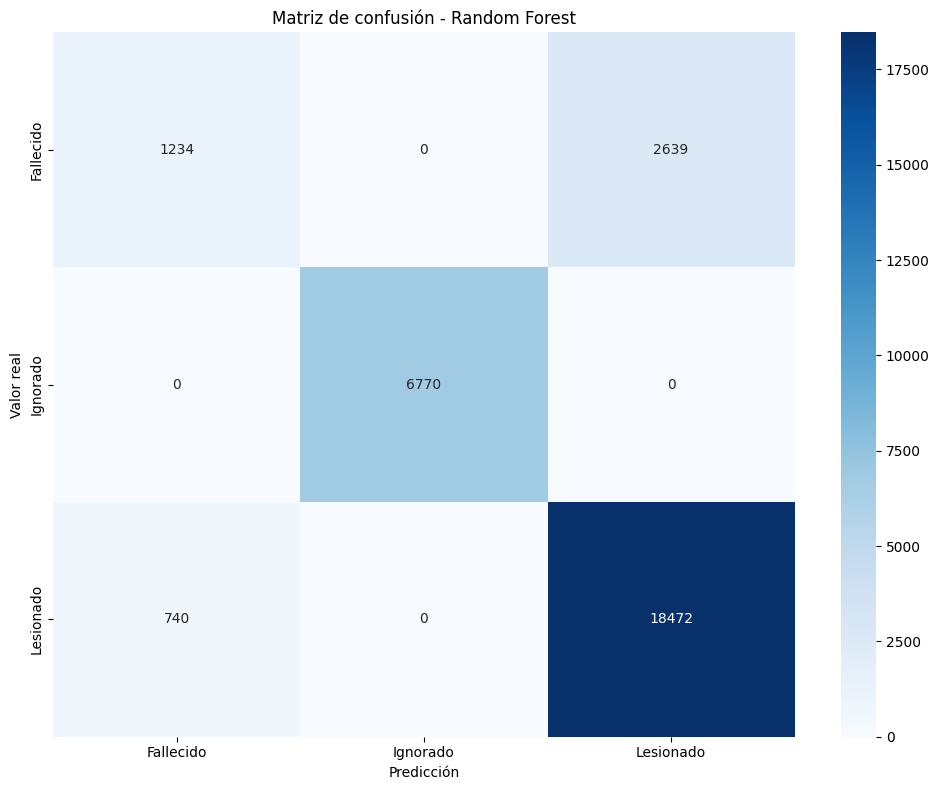

In [7]:
# Visualización de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión - Random Forest')
plt.tight_layout()
plt.show()

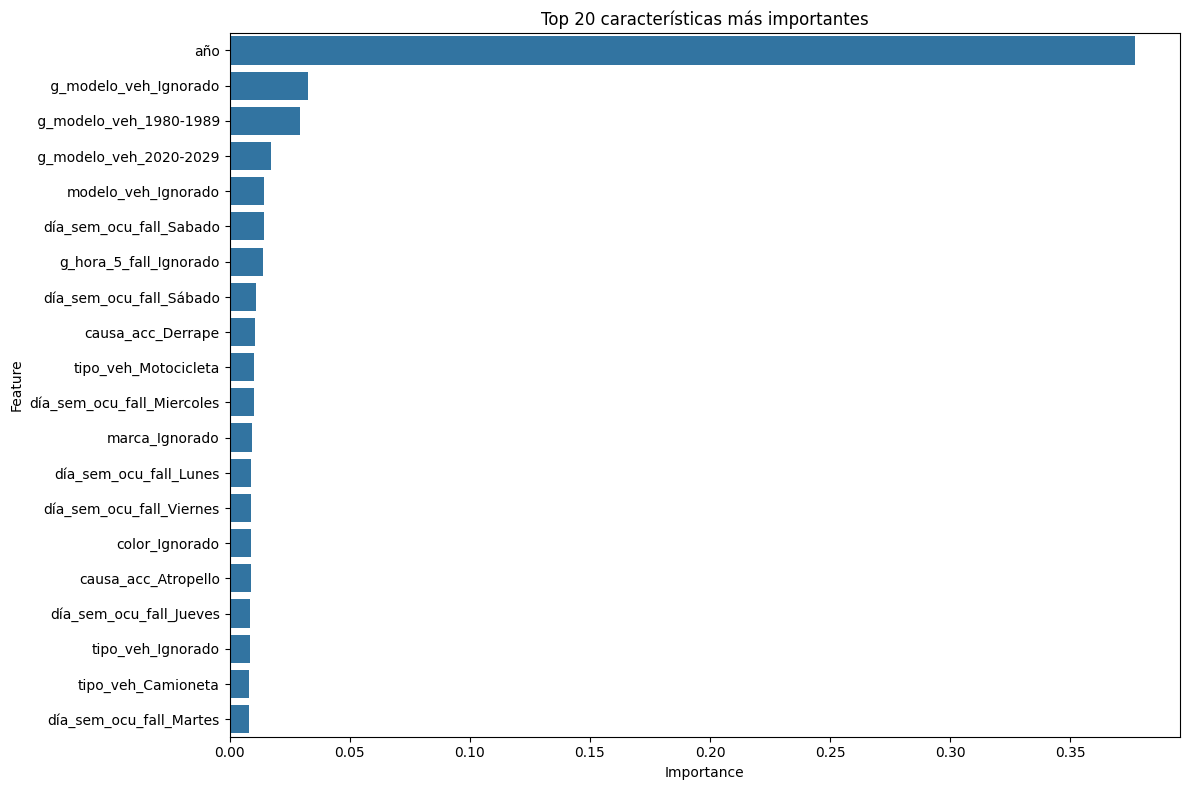

In [8]:
# Obtener las 20 características más importantes
feature_names = X_encoded.columns
feature_importance = rf_model.feature_importances_

# Crear DataFrame para visualizar
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Ordenar por importancia descendente
importance_df = importance_df.sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 20 características más importantes')
plt.tight_layout()
plt.show()


In [ ]:
# 7. Ajuste de hiperparámetros (opcional)

# Definir espacio de hiperparámetros a explorar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1  # Usar todos los núcleos disponibles
)

grid_search.fit(X_train, y_train)

print("\nMejores hiperparámetros:")
print(grid_search.best_params_)
print(f"Mejor exactitud: {grid_search.best_score_:.4f}")

# Usar el mejor modelo
best_rf_model = grid_search.best_estimator_